# Manipulation de la Donnée

## Téléchargement des données

In [1]:
!pip install kaggle

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 74% 19.0M/25.7M [00:00<00:00, 62.8MB/s]
100% 25.7M/25.7M [00:00<00:00, 72.0MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


## Chargement des données

In [2]:
import pandas as pd

imdb_df = pd.read_csv("/content/IMDB Dataset.csv")

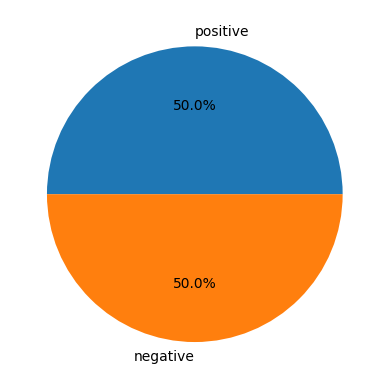

In [3]:
import matplotlib.pyplot as plt

sentiment_counts = imdb_df['sentiment'].value_counts()

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.show()

## Nettoyage et Prétraitement des Textes

### Suppression des tags html du contenu de la colonne review

In [4]:
from bs4 import BeautifulSoup

imdb_df['review'] = imdb_df['review'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

<ipython-input-4-f0b0e7e04f1f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  imdb_df['review'] = imdb_df['review'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


### Suppression de la ponctuation


In [5]:
import string

imdb_df['review'] = imdb_df['review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

### Passage en minuscules (lowercase)

In [6]:
imdb_df['review'] = imdb_df['review'].apply(lambda x: x.lower())

### Suppression des stop words

In [7]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

imdb_df['review'] = imdb_df['review'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Lemmatisation



In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
from textblob import Word
imdb_df['review'] = imdb_df['review'].apply(lambda x: " ".join([Word(word).
lemmatize() for word in x.split()]))

## Tokenisation et Padding et Encodage des Labels

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import spacy

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(imdb_df['review'])
sequences = tokenizer.texts_to_sequences(imdb_df['review'])

padded_sequences = pad_sequences(sequences)
imdb_df['padded_sequences'] = list(padded_sequences)

label_encoder = LabelEncoder()
imdb_df['encoded_label'] = label_encoder.fit_transform(imdb_df['sentiment'])

In [12]:
imdb_df

,review,sentiment,padded_sequences,encoded_label
0,one reviewer mentioned watching 1 oz episode y...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,wonderful little production filming technique ...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,thought wonderful way spend time hot summer we...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,basically there family little boy jake think t...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,petter matteis love time money visually stunni...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...
49995,thought movie right good job wasnt creative or...,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
49996,bad plot bad dialogue bad acting idiotic direc...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
49997,catholic taught parochial elementary school nu...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
49998,im going disagree previous comment side maltin...,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


## Séparation des données

In [13]:
from sklearn.model_selection import train_test_split

X = padded_sequences

y = imdb_df['encoded_label']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Entraînement de 3 Modèles

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

##Modèle LSTM from scratch :

In [15]:
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

In [17]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history = model_lstm.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping, lr_decay])

Epoch 1/50
1000/1000 [==============================] - 166s 160ms/step - loss: 0.4830 - accuracy: 0.7581 - val_loss: 0.4033 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - 119s 119ms/step - loss: 0.2710 - accuracy: 0.8929 - val_loss: 0.2778 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - 105s 105ms/step - loss: 0.2150 - accuracy: 0.9192 - val_loss: 0.2647 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 4/50
1000/1000 [==============================] - 104s 104ms/step - loss: 0.1791 - accuracy: 0.9358 - val_loss: 0.2824 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 5/50
1000/1000 [==============================] - 101s 101ms/step - loss: 0.1460 - accuracy: 0.9492 - val_loss: 0.3112 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 6/50
1000/1000 [==============================] - 100s 100ms/step - loss: 0.0859 - accuracy: 0.9761 - val_loss: 0.3730 - val_accuracy: 0.8880 - lr: 1.0000e-04


In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## Predict classes or probabilities for the test data

In [20]:
y_pred = model_lstm.predict(X_test)

313/313 [==============================] - 13s 38ms/step


In [21]:
# Calculate accuracy
# accuracy = accuracy_score(Y_test, y_pred)

# Calculate AUC
auc = roc_auc_score(Y_test, y_pred)

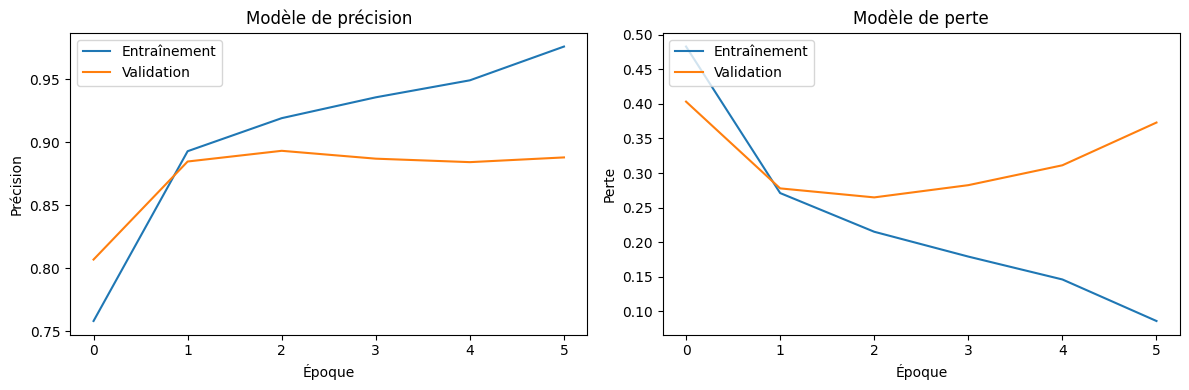

250/250 [==============================] - 8s 34ms/step


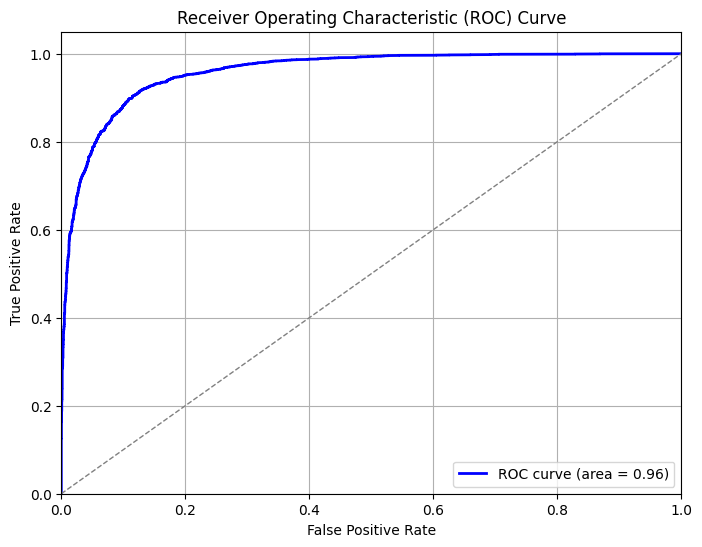

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


def plot_learning_curves(history):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Modèle de précision')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend(['Entraînement', 'Validation'], loc='upper left')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Modèle de perte')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend(['Entraînement', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


from sklearn.metrics import roc_auc_score

def plot_roc_curve(model, X_val, Y_val):

    Y_pred_prob = model.predict(X_val)

    fpr, tpr, _ = roc_curve(Y_val, Y_pred_prob)


    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_curve(model_lstm, X_val, Y_val)


##Modèle LSTM avec Attention :

In [36]:
max_sequence_length = 100  # Desired sequence length
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val, maxlen=max_sequence_length)

In [40]:
from tensorflow.keras.optimizers import Adam

# Définir l'optimiseur Adam avec les paramètres spécifiés
optim = Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name="adam"
)

In [41]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention, Flatten
from tensorflow.keras.models import Model

input_layer = Input(shape=(100,))

embedding_layer = Embedding(input_dim=5000, output_dim=128)(input_layer)

lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)

attention_layer = Attention()([lstm_layer, lstm_layer])

attention_layer = Flatten()(attention_layer)

output_layer = Dense(units=1, activation='sigmoid')(attention_layer)  # for binary classification

model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)

model_lstm_attention.compile(optimizer= optim, loss='binary_crossentropy', metrics=['accuracy'])

model_lstm_attention.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 100, 128)             640000    ['input_2[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               (None, 100, 128)             131584    ['embedding_2[0][0]']         
                                                                                                  
 attention_1 (Attention)     (None, 100, 128)             0         ['lstm_3[0][0]',              
                                                                     'lstm_3[0][0]']        

In [42]:
history2 = model_lstm_attention.fit(
    X_train_padded, Y_train,  # Training data
    epochs=50,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=(X_val_padded, Y_val),  # Validation data
    callbacks=[early_stopping, lr_decay]  # Optional callbacks
)

Epoch 1/50
1000/1000 [==============================] - 47s 43ms/step - loss: 0.3675 - accuracy: 0.8325 - val_loss: 0.3017 - val_accuracy: 0.8737 - lr: 5.0000e-04
Epoch 2/50
1000/1000 [==============================] - 14s 14ms/step - loss: 0.2625 - accuracy: 0.8915 - val_loss: 0.2959 - val_accuracy: 0.8755 - lr: 5.0000e-04
Epoch 3/50
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2281 - accuracy: 0.9068 - val_loss: 0.3056 - val_accuracy: 0.8719 - lr: 5.0000e-04
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1895 - accuracy: 0.9253 - val_loss: 0.3146 - val_accuracy: 0.8748 - lr: 5.0000e-04
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1014 - accuracy: 0.9654 - val_loss: 0.4458 - val_accuracy: 0.8656 - lr: 5.0000e-05


In [43]:
y_pred_proba = model_lstm_attention.predict(X_val_padded)

if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] == 1:
    y_pred_proba = y_pred_proba.ravel()

Y_val = np.array(Y_val).ravel()

assert len(Y_val) == len(y_pred_proba), "Mismatch in number of samples between Y_val and predictions"

fpr, tpr, thresholds = roc_curve(Y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)


250/250 [==============================] - 1s 3ms/step


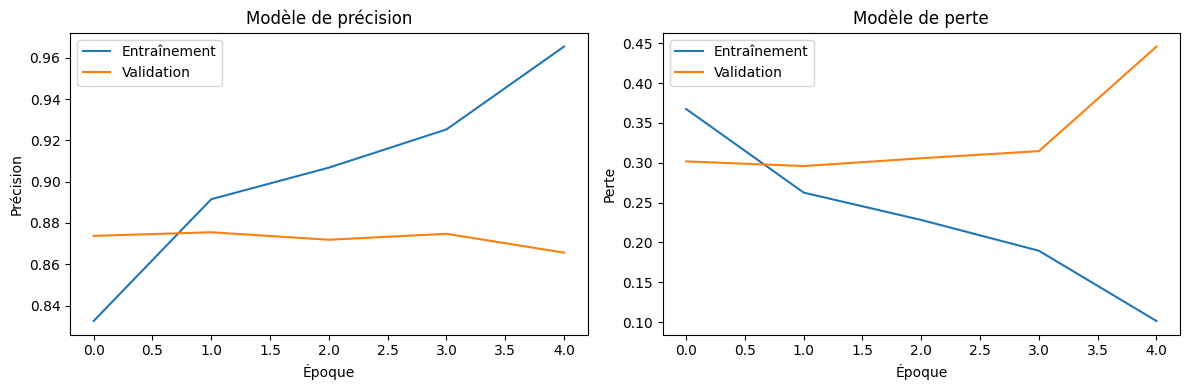

In [44]:
plot_learning_curves(history2)

250/250 [==============================] - 1s 5ms/step


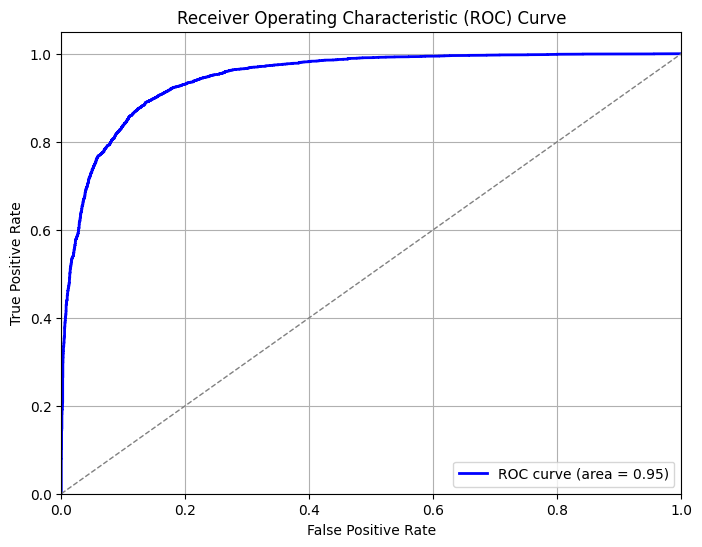

In [45]:
plot_roc_curve(model_lstm_attention, X_val_padded, Y_val)

##Modèle Transformer :

##Sauvegarde des Modèles